In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

ROOT = "../"
DEMOGRAPHICS_CSV = f"{ROOT}Dataset/Demographics/demographics.csv"
SENSING_CSV = f"{ROOT}Dataset/Sensing/sensing.csv"
GENERAL_EMA_CSV = f"{ROOT}Dataset/EMA/general_ema.csv"
COVID_EMA_CSV = f"{ROOT}Dataset/EMA/covid_ema.csv"

df = pd.read_csv(DEMOGRAPHICS_CSV)
sensing_df = pd.read_csv(SENSING_CSV)
general_ema = pd.read_csv(GENERAL_EMA_CSV)
covid_ema = pd.read_csv(COVID_EMA_CSV)

In [2]:
def drop_rare_categories(df, threshold=0.05, exclude_columns=None):
    # If exclude_columns is None, initialize it as an empty list
    if exclude_columns is None:
        exclude_columns = []
    
    # Identify categorical columns, excluding specified columns like 'u_id'
    categorical_columns = [col for col in df.select_dtypes(include=['object', 'category']).columns if col not in exclude_columns]
    
    # Loop through each categorical column to drop rare categories
    for col in categorical_columns:
        # Calculate the frequency of each category as a proportion
        value_counts = df[col].value_counts(normalize=True)
        
        # Identify categories that appear in less than the threshold percentage
        rare_categories = value_counts[value_counts < threshold].index
        print(rare_categories)
        
        # Drop rows with these rare categories
        df = df[~df[col].isin(rare_categories)]
    
    return df


def one_hot_encode_categoricals(df, exclude_columns=None):
    # If exclude_columns is None, initialize it as an empty list
    if exclude_columns is None:
        exclude_columns = []
    
    # Identify categorical columns, excluding specified columns
    categorical_columns = [col for col in df.select_dtypes(include=['object', 'category']).columns if col not in exclude_columns]
    
    # Perform one-hot encoding on the categorical columns
    df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
    
    return df_encoded


In [3]:
def get_academic_quarter(day):
    """
    Convert YYYYMMDD to academic quarter (0-3)
    0: Fall (mid-Sept to late Nov)
    1: Winter (Jan to early Mar)
    2: Spring (late Mar to early June)
    3: Summer (mid-June to early Sept)
    """
    # Convert string date to datetime
    date = pd.to_datetime(str(day), format='%Y%m%d')
    month = date.month
    day = date.day
    
    if (month == 9 and day >= 15) or month == 10 or (month == 11 and day <= 30):
        return 0  # Fall
    elif month == 1 or month == 2 or (month == 3 and day <= 15):
        return 1  # Winter
    elif (month == 3 and day > 15) or month == 4 or month == 5 or (month == 6 and day <= 10):
        return 2  # Spring
    else:
        return 3  # Summer

In [4]:
ema_data = pd.merge(general_ema, covid_ema , on=['uid', 'day'], how='inner')
print(ema_data.shape)
#ema_data = ema_data.dropna(subset=['survey_answer_column']) 

(16508, 29)


In [5]:
merged_data = pd.merge(sensing_df, df, on='uid', how='inner')

df_cleaned = drop_rare_categories(merged_data, threshold=0.01, exclude_columns=['uid'])
df_cleaned = one_hot_encode_categoricals(df_cleaned, exclude_columns=['uid'])

df_cleaned.update(df_cleaned.drop(columns=['uid']).fillna(df_cleaned.drop(columns=['uid']).median()))
df_cleaned.shape

Index(['both'], dtype='object', name='gender')
Index(['american indian/alaska native', 'alaskan native/white',
       'american indian/white'],
      dtype='object', name='race')


(209916, 656)

In [6]:
ema_data = ema_data.dropna()
print(ema_data.shape)

print(merged_data.shape)
merged_data = pd.merge(df_cleaned, ema_data, on=['uid', 'day'], how='inner')
print(merged_data.shape)

(2024, 29)
(214759, 653)
(1960, 683)


In [30]:
merged_data['daySTR'] = pd.to_datetime(merged_data['day'].astype(str), format='%Y%m%d')

merged_data['year'] = merged_data['daySTR'].dt.year
merged_data['month'] = merged_data['daySTR'].dt.month
merged_data['day_of_week'] = merged_data['daySTR'].dt.dayofweek  # 0=Monday, 6=Sunday

merged_data = merged_data.drop(columns=['daySTR'])
merged_data['quarter'] = merged_data['day'].apply(get_academic_quarter)
# Add a 'weekday' column: 0 for weekend, 1 for weekday
merged_data['weekday'] = merged_data['day_of_week'].apply(lambda x: 0 if x in [5, 6] else 1)

# Display the relevant columns to verify
merged_data[['day', 'year', 'month', 'day_of_week', 'quarter', 'weekday']].head()

,day,year,month,day_of_week,quarter,weekday
0,20200320,2020,3,4,2,1
1,20200327,2020,3,4,2,1
2,20200331,2020,3,1,2,1
3,20200410,2020,4,4,2,1
4,20200417,2020,4,4,2,1


In [8]:
quarter_grouped = merged_data.groupby('quarter')
print("counts",[len(quarter_grouped.get_group(i)) for i in range(4)])
print("unique users in q0", len(quarter_grouped.get_group(0).groupby('uid')))
quarter_grouped.get_group(0)

counts [158, 125, 1336, 341]
unique users in q0 71


,uid,is_ios,day,act_in_vehicle_ep_0,act_in_vehicle_ep_1,act_in_vehicle_ep_2,act_in_vehicle_ep_3,act_in_vehicle_hr_0,act_in_vehicle_hr_1,act_in_vehicle_hr_10,...,COVID-5,COVID-6,COVID-7,COVID-8,COVID-9,COVID-10,year,month,day_of_week,quarter
36,3dad5f11680b432159b65838119ab87e,1,20200919,19825,2896,16929,0,0,0,2573,...,6.0,4.0,6.0,4.0,4.0,3.0,2020,9,5,0
37,3dad5f11680b432159b65838119ab87e,1,20201031,8383,0,3950,4433,0,0,431,...,7.0,6.0,3.0,4.0,4.0,4.0,2020,10,5,0
38,3dad5f11680b432159b65838119ab87e,1,20201107,0,0,0,0,0,0,0,...,5.0,5.0,2.0,4.0,4.0,3.0,2020,11,5,0
52,a23be0935798553a76b4e74cfc1740f1,1,20200919,13535,0,10417,3118,0,0,2851,...,4.0,4.0,1.0,5.0,5.0,4.0,2020,9,5,0
82,f4d488e3c8096842b645280d8f01ae43,0,20200926,2674,1126,1548,0,0,0,0,...,4.0,6.0,2.0,5.0,4.0,3.0,2020,9,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1863,12f90c19f2c2b74ec542b62e74e7cad1,1,20201031,5276,0,2922,2354,0,0,1382,...,4.0,5.0,3.0,3.0,4.0,3.0,2020,10,5,0
1864,12f90c19f2c2b74ec542b62e74e7cad1,1,20201107,80,0,80,0,0,0,0,...,4.0,4.0,2.0,4.0,4.0,4.0,2020,11,5,0
1867,6294895f1093b3878b385812d65c3197,1,20201003,6580,0,2769,3811,0,0,0,...,4.0,7.0,3.0,4.0,5.0,4.0,2020,10,5,0
1904,84875d7ec9c81d58d687aa4805c35c77,1,20201010,2843,0,2843,0,0,0,480,...,4.0,5.0,1.0,4.0,4.0,5.0,2020,10,5,0


In [9]:
def create_timestep_rows(df, user_col, time_col, feature_cols):
    # Ensure the data is sorted by user and time
    df = df.sort_values(by=[user_col, time_col])
    
    # List to store the new rows for all users
    expanded_data = []
    
    # Group by user
    for user, user_data in df.groupby(user_col):
        user_data = user_data.reset_index(drop=True)
        
        # Create previous timestep values by shifting
        prev_values = user_data[feature_cols].shift(1).add_prefix('prev_')
        
        # Combine previous timestep values with current timestep values
        combined = pd.concat([prev_values, user_data[feature_cols]], axis=1)
        
        # Add user and time columns back for identification
        combined[user_col] = user_data[user_col]
        combined[time_col] = user_data[time_col]
        
        # Drop rows where prev_ values are NaN (first row of each user)
        combined = combined.dropna().reset_index(drop=True)
        
        # Append to the list
        expanded_data.append(combined)

    
    # Combine all user data into a single DataFrame
    result_df = pd.concat(expanded_data, axis=0).reset_index(drop=True)
    return result_df


#EXAMPLE WITH QUARTER 0 DATA
user_col = 'uid'  
time_col = 'day'  

target_cols = list(ema_data.columns)
target_cols.remove("uid")
target_cols.remove("day")

feature_cols = [col for col in merged_data.columns if col not in target_cols + ['uid']]  # Exclude 'uid' as well

lagged_features = list(merged_data.columns)
lagged_features.remove("uid")

timestep_df = create_timestep_rows(quarter_grouped.get_group(0), user_col=user_col, time_col=time_col, feature_cols=lagged_features)

# Display the new DataFrame
timestep_df.shape


(87, 1373)

In [10]:
timestep_dfs = [create_timestep_rows(quarter_grouped.get_group(i), user_col=user_col, time_col=time_col, feature_cols=lagged_features) for i in range(4)]
combined_quarters_df = pd.concat(timestep_dfs, axis=0).reset_index(drop=True)
combined_quarters_df.shape


(1560, 1373)

In [11]:
combined_quarters_df.select_dtypes(exclude=['number']).columns

Index(['prev_gender_M', 'prev_race_black', 'prev_race_more than one',
       'prev_race_other/hispanic', 'prev_race_white', 'gender_M', 'race_black',
       'race_more than one', 'race_other/hispanic', 'race_white', 'uid'],
      dtype='object')

39
(1345, 27)
(39, 27)


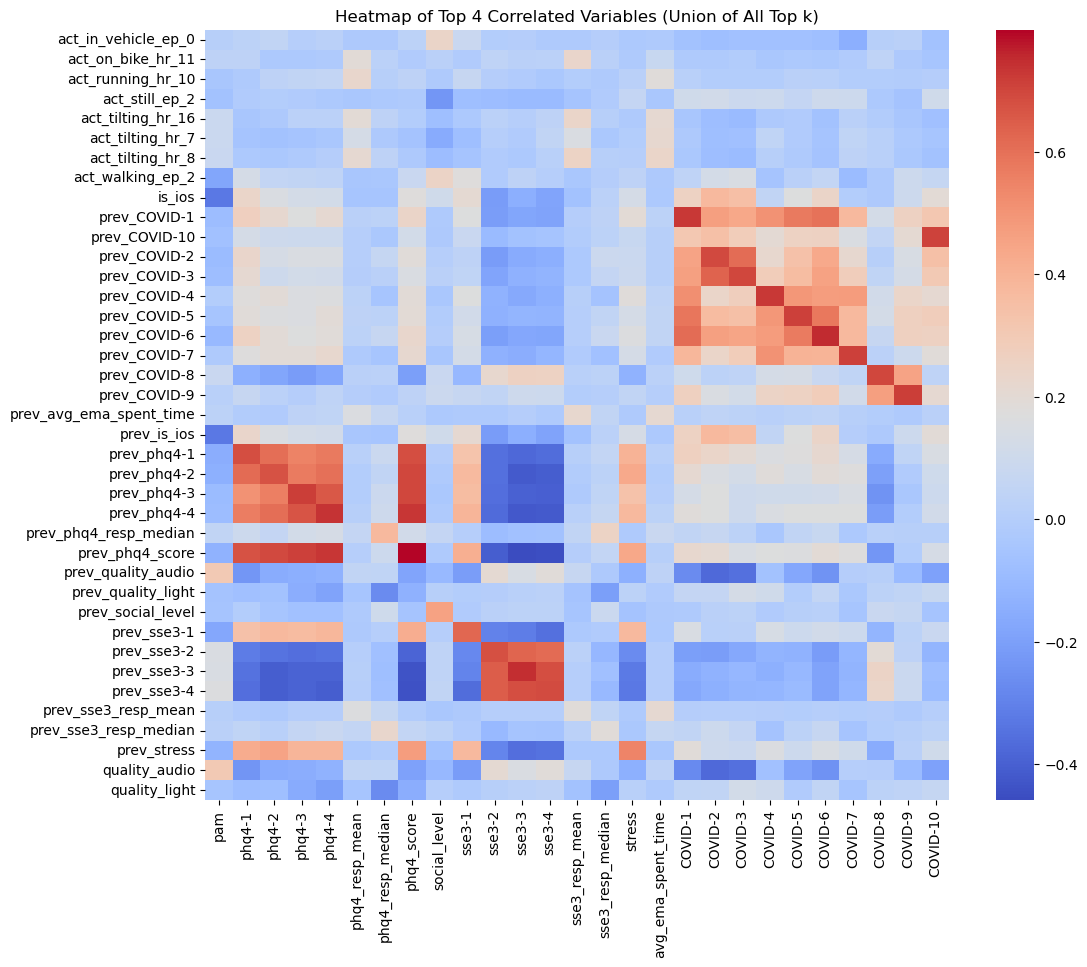

,pam,phq4-1,phq4-2,phq4-3,phq4-4,phq4_resp_mean,phq4_resp_median,phq4_score,social_level,sse3-1,...,COVID-1,COVID-2,COVID-3,COVID-4,COVID-5,COVID-6,COVID-7,COVID-8,COVID-9,COVID-10
act_in_vehicle_ep_0,0.012841,0.032386,0.048385,0.006982,0.021775,-0.020738,-0.021945,0.030316,0.241396,0.081425,...,-0.060235,-0.075572,-0.065146,-0.064998,-0.069037,-0.078091,-0.143807,0.011877,0.023225,-0.059976
act_on_bike_hr_11,0.034774,0.034536,-0.029672,-0.030309,-0.016052,0.194404,0.024884,-0.012782,0.021371,-0.014995,...,-0.019166,-0.016609,-0.009919,-0.038664,-0.029879,-0.034778,-0.010924,0.041196,-0.025497,-0.046039
act_running_hr_10,-0.044249,-0.016152,0.034492,0.049129,0.054955,0.226931,0.010219,0.035940,-0.020544,0.071305,...,0.014137,-0.004624,-0.005169,-0.002356,0.018866,0.016946,-0.002753,-0.002686,-0.009786,0.002929
act_still_ep_2,-0.062662,-0.011795,-0.001892,-0.014112,-0.028222,-0.036551,-0.027597,-0.017701,-0.234876,-0.078460,...,0.111049,0.115060,0.088690,0.097085,0.059082,0.101822,0.096782,-0.026251,-0.056603,0.108604
act_tilting_hr_16,0.083771,-0.042270,-0.021383,0.026549,0.027313,0.198233,0.037589,-0.001557,-0.079541,-0.029945,...,-0.044592,-0.082371,-0.098988,-0.022005,-0.015250,-0.063574,0.020322,-0.007644,-0.040869,-0.073295
act_tilting_hr_7,0.087303,-0.054138,-0.062339,-0.054701,-0.040143,0.129569,-0.021655,-0.059916,-0.158685,-0.074912,...,-0.022723,-0.076054,-0.072891,0.043602,-0.014469,-0.053314,0.045670,0.018559,-0.026386,-0.046479
act_tilting_hr_8,0.078698,-0.027805,-0.032398,-0.017860,0.003382,0.213219,0.037740,-0.020869,-0.085526,-0.054490,...,-0.031916,-0.080400,-0.091162,0.011262,-0.017266,-0.057641,0.036054,0.017349,-0.032011,-0.061601
act_walking_ep_2,-0.182250,0.127843,0.056861,0.048251,0.039550,-0.042310,-0.036791,0.078246,0.245119,0.178539,...,0.041486,0.124304,0.148144,-0.054487,0.021467,0.057216,-0.092964,-0.024204,0.097158,0.063871
is_ios,-0.329243,0.237820,0.153785,0.125965,0.117674,-0.045353,-0.048414,0.178305,0.109338,0.208517,...,0.256923,0.373661,0.352131,0.052899,0.168449,0.242438,-0.003184,-0.022175,0.093430,0.197252
prev_COVID-1,-0.087530,0.269438,0.217736,0.167106,0.211979,0.023322,0.029753,0.243990,-0.016046,0.170378,...,0.727048,0.467242,0.439736,0.509110,0.578415,0.597968,0.374160,0.122027,0.260243,0.314585


In [12]:
# Define the top k value
top_k = 4  # Adjust as needed

# Compute the correlation matrix

corr_matrix = combined_quarters_df.drop(columns=['uid']).corr()[target_cols]
corr_matrix = corr_matrix.drop(index=target_cols, errors='ignore')
#corr_matrix = combined_quarters_df[target_cols].corr()

# Mask self-correlations by setting the diagonal to NaN
#np.fill_diagonal(corr_matrix.values, np.nan)

# Collect top k correlated features for each feature
top_k_features = set()  # Use a set to ensure uniqueness

for feature in corr_matrix.columns:
    # Get the top k correlated features for the current feature
    top_k_corr = corr_matrix[feature].abs().nlargest(top_k).index
    top_k_features.update(top_k_corr)

# Convert the set to a sorted list for consistent ordering
top_k_features = sorted(top_k_features)
print(len(top_k_features))
print(corr_matrix.shape)
print(corr_matrix.loc[top_k_features].shape)

# Filter the correlation matrix to only include the union of top k features
filtered_corr_matrix = corr_matrix.loc[top_k_features]

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title(f"Heatmap of Top {top_k} Correlated Variables (Union of All Top k)")
plt.show()
filtered_corr_matrix

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

def train_and_evaluate_models_normalized(df, feature_columns, target_columns):
    results = {}
    
    # Loop through each target column (survey question)
    for target in target_columns:
        print(f"Training model for target: {target}")
        
        # Split data into features (X) and the current target (y)
        X = df[feature_columns]
        y = df[target]
        
        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Initialize and train the linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = model.predict(X_test)
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # Normalize the RMSE by dividing by the range of the target variable
        y_range = y.max() - y.min() if y.max() != y.min() else 1  # Avoid division by zero
        nrmse = rmse / y_range
        
        # Store results
        results[target] = {'model': model, 'nrmse': nrmse}
        print(f"Normalized RMSE for {target}: {nrmse}\n")
    
    return results

def plot_evaluation_results(results, metric_name):
    # Extract the target variable names and their corresponding metric values
    targets = list(results.keys())
    metrics = [results[target][metric_name] for target in targets]
    
    # Create a bar plot
    plt.figure(figsize=(20, 6))
    plt.bar(targets, metrics, color='skyblue', edgecolor='black')
    
    # Add labels and title
    plt.xlabel("Target Variable")
    plt.ylabel(metric_name.replace('_', ' ').title())
    plt.title(f"{metric_name.replace('_', ' ').title()} for Each Target Variable")
    plt.xticks(rotation=45)
    
    # Show the plot
    plt.tight_layout()
    plt.show()


In [21]:
results_selected_features = train_and_evaluate_models_normalized(combined_quarters_df, top_k_features, target_cols)

Training model for target: pam
Normalized RMSE for pam: 0.2766832673533898

Training model for target: phq4-1
Normalized RMSE for phq4-1: 0.1882884939552906

Training model for target: phq4-2
Normalized RMSE for phq4-2: 0.20346480151156268

Training model for target: phq4-3
Normalized RMSE for phq4-3: 0.19360912084615467

Training model for target: phq4-4
Normalized RMSE for phq4-4: 0.19874196818390052

Training model for target: phq4_resp_mean
Normalized RMSE for phq4_resp_mean: 0.05697171121721676

Training model for target: phq4_resp_median
Normalized RMSE for phq4_resp_median: 0.04586368354714519

Training model for target: phq4_score
Normalized RMSE for phq4_score: 0.1570530064406151

Training model for target: social_level
Normalized RMSE for social_level: 0.2873758208164774

Training model for target: sse3-1
Normalized RMSE for sse3-1: 0.19202378037721674

Training model for target: sse3-2
Normalized RMSE for sse3-2: 0.1858570607028352

Training model for target: sse3-3
Normaliz

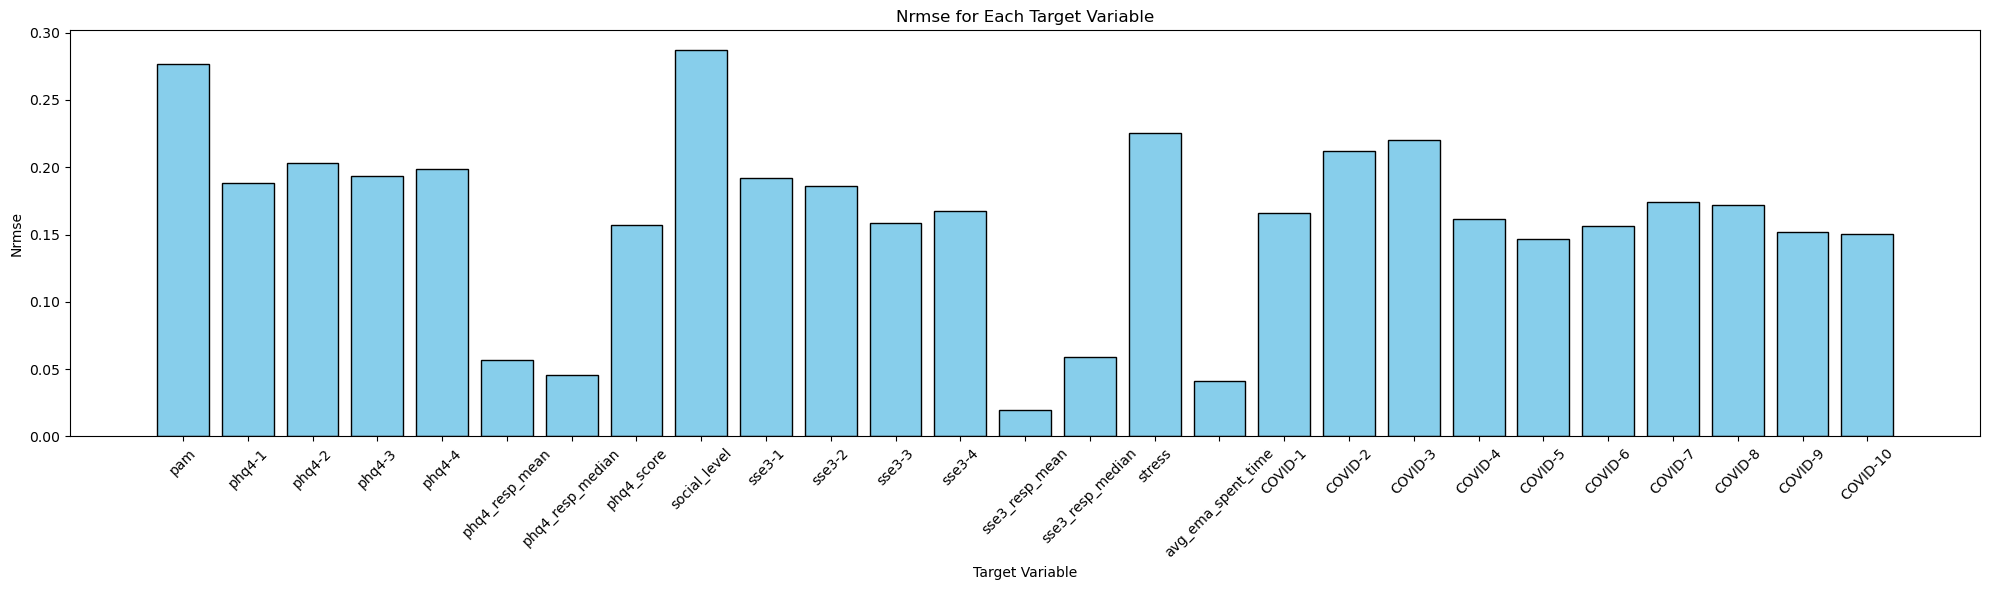

In [22]:
plot_evaluation_results(results_selected_features, metric_name='nrmse')

In [25]:
day_grouped = merged_data.groupby('day_of_week')
print("counts",[len(day_grouped.get_group(i)) for i in range(7)])
print("unique users in day0", len(day_grouped.get_group(0).groupby('uid')))
day_grouped.get_group(0)

counts [125, 115, 164, 193, 188, 1016, 159]
unique users in day0 83


,uid,is_ios,day,act_in_vehicle_ep_0,act_in_vehicle_ep_1,act_in_vehicle_ep_2,act_in_vehicle_ep_3,act_in_vehicle_hr_0,act_in_vehicle_hr_1,act_in_vehicle_hr_10,...,COVID-5,COVID-6,COVID-7,COVID-8,COVID-9,COVID-10,year,month,day_of_week,quarter
62,2b3d267f18830c3c257b382edabef246,1,20200330,2151,0,2151,0,0,0,0,...,5.0,4.0,5.0,4.0,4.0,5.0,2020,3,0,2
64,2b3d267f18830c3c257b382edabef246,1,20200420,1876,0,1876,0,0,0,0,...,6.0,6.0,6.0,6.0,6.0,6.0,2020,4,0,2
67,f4d488e3c8096842b645280d8f01ae43,0,20200323,0,0,0,0,0,0,0,...,4.0,5.0,2.0,6.0,4.0,5.0,2020,3,0,2
88,3bb377ba0acb7d8916010184df36aa57,1,20200420,2296,0,2296,0,0,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,2020,4,0,2
95,8391d8b451084771d0affcc26e34d773,1,20200406,0,0,0,0,0,0,0,...,4.0,5.0,4.0,4.0,5.0,4.0,2020,4,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1851,bea4c7250c8631ddfacf57dfa386caba,1,20200413,3078,0,3078,0,0,0,0,...,4.0,7.0,7.0,3.0,5.0,7.0,2020,4,0,2
1872,58863d024fc04ff1c3082e2c81e14cf2,1,20200406,0,0,0,0,0,0,0,...,4.0,5.0,2.0,4.0,4.0,6.0,2020,4,0,2
1873,58863d024fc04ff1c3082e2c81e14cf2,1,20200413,0,0,0,0,0,0,0,...,5.0,5.0,1.0,4.0,4.0,6.0,2020,4,0,2
1920,f5529fbae87a8d170937d3e39d5a63cc,1,20200413,0,0,0,0,0,0,0,...,7.0,7.0,7.0,7.0,7.0,7.0,2020,4,0,2


In [26]:
timestep_days_dfs = [create_timestep_rows(day_grouped.get_group(i), user_col=user_col, time_col=time_col, feature_cols=lagged_features) for i in range(7)]
combined_days_df = pd.concat(timestep_days_dfs, axis=0).reset_index(drop=True)
combined_days_df.shape


(1225, 1373)

39
(1345, 27)
(39, 27)


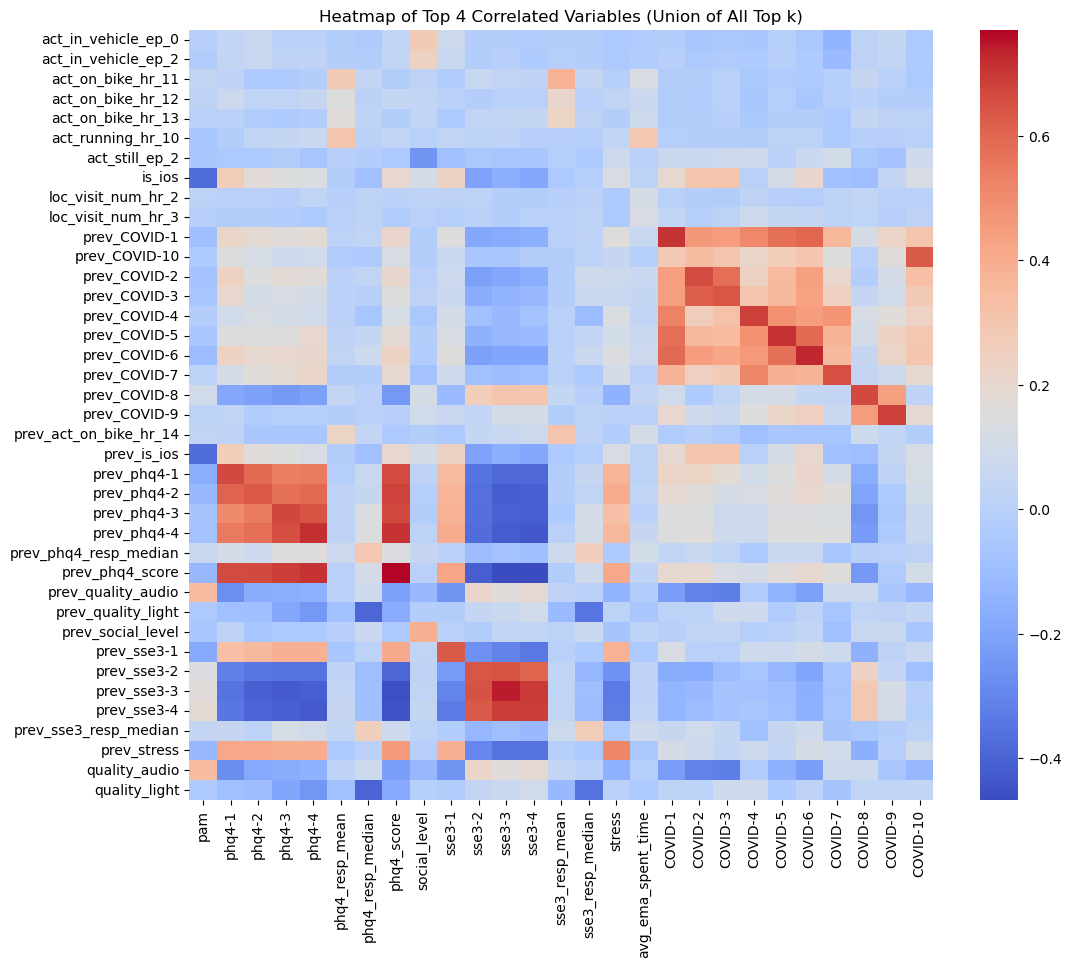

,pam,phq4-1,phq4-2,phq4-3,phq4-4,phq4_resp_mean,phq4_resp_median,phq4_score,social_level,sse3-1,...,COVID-1,COVID-2,COVID-3,COVID-4,COVID-5,COVID-6,COVID-7,COVID-8,COVID-9,COVID-10
act_in_vehicle_ep_0,-0.005334,0.035939,0.056176,0.008415,0.011638,-0.017781,-0.032289,0.030826,0.274300,0.075054,...,-0.012735,-0.055461,-0.050657,-0.056429,-0.010321,-0.049545,-0.138348,0.021249,0.046090,-0.045054
act_in_vehicle_ep_2,-0.026058,0.041837,0.059949,0.018019,0.023904,-0.013587,-0.019475,0.039780,0.243159,0.057312,...,-0.004016,-0.037704,-0.030480,-0.032289,-0.003720,-0.032811,-0.112195,0.020615,0.039224,-0.033865
act_on_bike_hr_11,0.041380,0.021528,-0.033782,-0.034780,-0.013488,0.284554,0.036319,-0.017960,0.021156,-0.024768,...,-0.021940,-0.015208,0.000248,-0.046696,-0.029989,-0.032517,-0.009947,0.054777,-0.001797,-0.043549
act_on_bike_hr_12,0.017574,0.070598,0.026963,0.027877,0.051831,0.152852,0.009093,0.049480,0.036626,0.007332,...,-0.017465,-0.023915,0.000527,-0.051700,-0.010979,-0.058817,-0.012070,0.007016,-0.016305,-0.014563
act_on_bike_hr_13,0.000748,0.011441,-0.026282,-0.033143,-0.022641,0.170554,0.025429,-0.020601,0.026640,-0.038832,...,-0.021488,-0.017863,-0.005514,-0.049334,-0.017493,-0.015593,-0.041875,0.045654,0.016830,0.012127
act_running_hr_10,-0.064617,-0.020035,0.034454,0.045684,0.061088,0.304209,0.008291,0.035385,0.001328,0.035146,...,-0.010429,-0.013512,-0.019706,-0.018472,0.012687,0.014890,-0.035454,-0.004148,-0.004425,-0.001522
act_still_ep_2,-0.052195,-0.037825,-0.036217,-0.017841,-0.061336,-0.004246,-0.015025,-0.044291,-0.254091,-0.085560,...,0.067531,0.067336,0.071737,0.081630,0.011422,0.061048,0.100536,-0.048300,-0.078330,0.085572
is_ios,-0.373447,0.270589,0.171892,0.150849,0.133720,-0.020235,-0.085165,0.203093,0.117644,0.241255,...,0.195885,0.305996,0.307949,0.002552,0.117584,0.207348,-0.086444,-0.095740,0.045017,0.126874
loc_visit_num_hr_2,0.013308,-0.002028,0.006513,-0.004924,0.029064,-0.004481,0.017779,0.008229,0.024389,0.018171,...,0.000185,-0.015171,-0.019732,0.024370,-0.003654,-0.010080,0.012346,0.037198,0.004366,-0.000489
loc_visit_num_hr_3,-0.004131,-0.018986,-0.014539,-0.024961,-0.033803,-0.001438,0.020850,-0.026138,0.002418,-0.008986,...,0.037968,-0.011382,0.012266,0.083188,0.047463,0.043389,0.013662,0.028133,-0.004337,0.017235


In [27]:
# Define the top k value
top_k = 4  # Adjust as needed

# Compute the correlation matrix

corr_matrix = combined_days_df.drop(columns=['uid']).corr()[target_cols]
corr_matrix = corr_matrix.drop(index=target_cols, errors='ignore')
#corr_matrix = combined_quarters_df[target_cols].corr()

# Mask self-correlations by setting the diagonal to NaN
#np.fill_diagonal(corr_matrix.values, np.nan)

# Collect top k correlated features for each feature
top_k_features = set()  # Use a set to ensure uniqueness

for feature in corr_matrix.columns:
    # Get the top k correlated features for the current feature
    top_k_corr = corr_matrix[feature].abs().nlargest(top_k).index
    top_k_features.update(top_k_corr)

# Convert the set to a sorted list for consistent ordering
top_k_features = sorted(top_k_features)
print(len(top_k_features))
print(corr_matrix.shape)
print(corr_matrix.loc[top_k_features].shape)

# Filter the correlation matrix to only include the union of top k features
filtered_corr_matrix = corr_matrix.loc[top_k_features]

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title(f"Heatmap of Top {top_k} Correlated Variables (Union of All Top k)")
plt.show()
filtered_corr_matrix

In [28]:
results_selected_features = train_and_evaluate_models_normalized(combined_days_df, top_k_features, target_cols)

Training model for target: pam
Normalized RMSE for pam: 0.2644256685791532

Training model for target: phq4-1
Normalized RMSE for phq4-1: 0.18953849410918755

Training model for target: phq4-2
Normalized RMSE for phq4-2: 0.21118664429229717

Training model for target: phq4-3
Normalized RMSE for phq4-3: 0.21727350863383563

Training model for target: phq4-4
Normalized RMSE for phq4-4: 0.18637906398589732

Training model for target: phq4_resp_mean
Normalized RMSE for phq4_resp_mean: 0.04876639621595579

Training model for target: phq4_resp_median
Normalized RMSE for phq4_resp_median: 0.06034488456045226

Training model for target: phq4_score
Normalized RMSE for phq4_score: 0.16044556082027425

Training model for target: social_level
Normalized RMSE for social_level: 0.29362435798503067

Training model for target: sse3-1
Normalized RMSE for sse3-1: 0.2270270294186816

Training model for target: sse3-2
Normalized RMSE for sse3-2: 0.18197709061801617

Training model for target: sse3-3
Norma

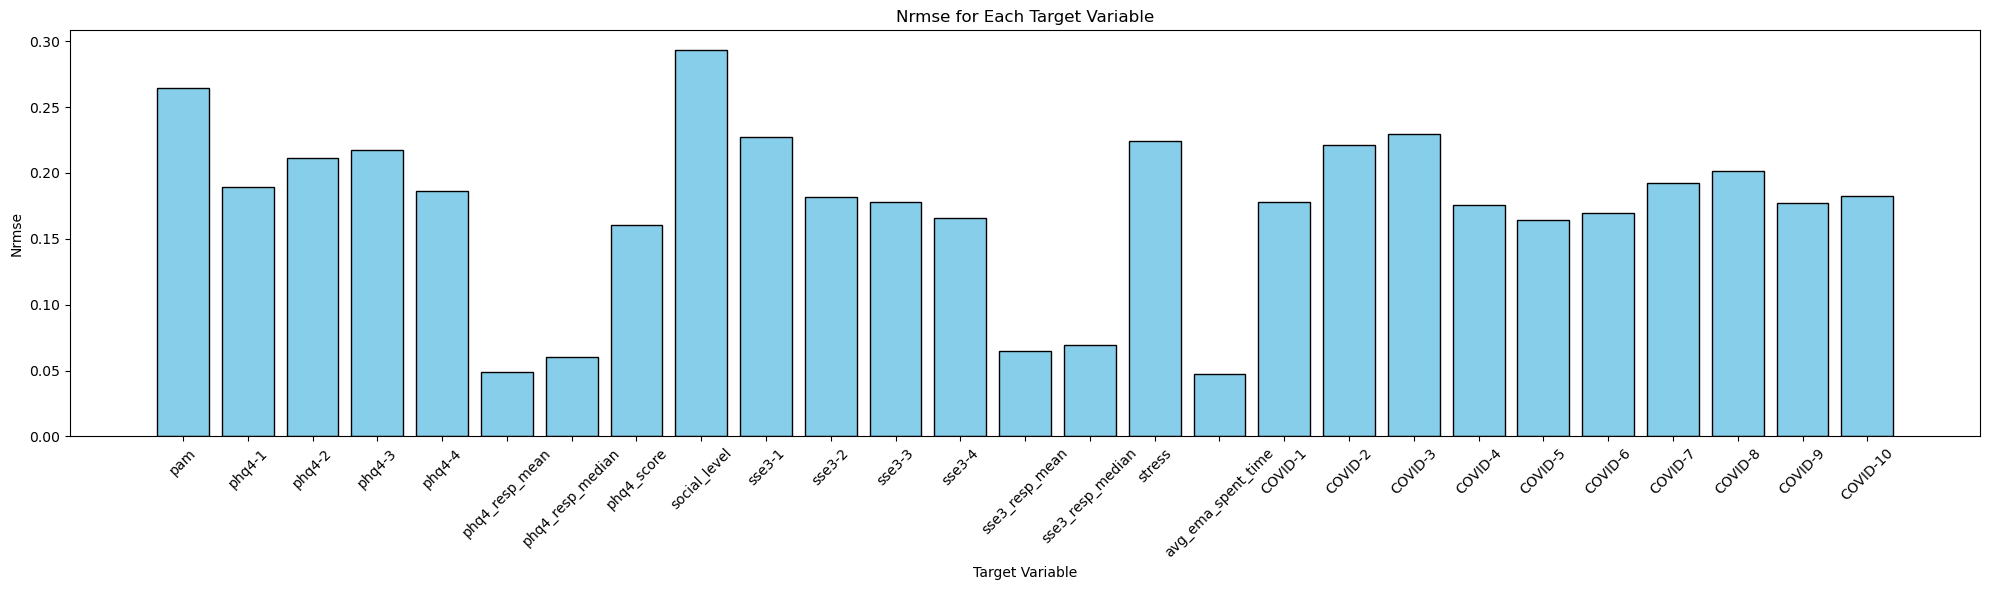

In [29]:
plot_evaluation_results(results_selected_features, metric_name='nrmse')

In [32]:
weekday_grouped = merged_data.groupby('weekday')
print("counts",[len(weekday_grouped.get_group(i)) for i in range(2)])
print("unique users in day0", len(weekday_grouped.get_group(0).groupby('uid')))
weekday_grouped.get_group(0)

counts [1175, 785]
unique users in day0 161


,uid,is_ios,day,act_in_vehicle_ep_0,act_in_vehicle_ep_1,act_in_vehicle_ep_2,act_in_vehicle_ep_3,act_in_vehicle_hr_0,act_in_vehicle_hr_1,act_in_vehicle_hr_10,...,COVID-6,COVID-7,COVID-8,COVID-9,COVID-10,year,month,day_of_week,quarter,weekday
7,1ff6d7f34acb354430e7323a35ff7703,1,20200606,0,0,0,0,0,0,0,...,4.0,2.0,2.0,1.0,3.0,2020,6,5,2,0
8,1ff6d7f34acb354430e7323a35ff7703,1,20200704,0,0,0,0,0,0,0,...,3.0,2.0,2.0,2.0,3.0,2020,7,5,3,0
9,1ff6d7f34acb354430e7323a35ff7703,1,20200718,223,0,223,0,0,0,0,...,3.0,2.0,3.0,5.0,3.0,2020,7,5,3,0
10,1ff6d7f34acb354430e7323a35ff7703,1,20200815,2248,0,2248,0,0,0,0,...,3.0,1.0,2.0,2.0,3.0,2020,8,5,3,0
11,1ff6d7f34acb354430e7323a35ff7703,1,20200829,2050,0,2050,0,0,0,0,...,3.0,2.0,2.0,4.0,3.0,2020,8,5,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,fe8ddda4ae8c71f7054ca024b82f5c98,1,20210828,1586,0,0,1586,0,0,0,...,2.0,3.0,3.0,3.0,4.0,2021,8,5,3,0
1945,fe8ddda4ae8c71f7054ca024b82f5c98,1,20220212,4263,0,2973,1290,0,0,86,...,3.0,4.0,4.0,4.0,5.0,2022,2,5,1,0
1953,6b0083d00297f9c03e00b2cde889b666,1,20200328,0,0,0,0,0,0,0,...,4.0,1.0,6.0,3.0,7.0,2020,3,5,2,0
1957,6b0083d00297f9c03e00b2cde889b666,1,20200418,0,0,0,0,0,0,0,...,2.0,2.0,5.0,2.0,4.0,2020,4,5,2,0


In [33]:
timestep_weekdays_dfs = [create_timestep_rows(weekday_grouped.get_group(i), user_col=user_col, time_col=time_col, feature_cols=lagged_features) for i in range(2)]
combined_weekdays_df = pd.concat(timestep_weekdays_dfs, axis=0).reset_index(drop=True)
combined_weekdays_df.shape


(1646, 1373)

40
(1345, 27)
(40, 27)


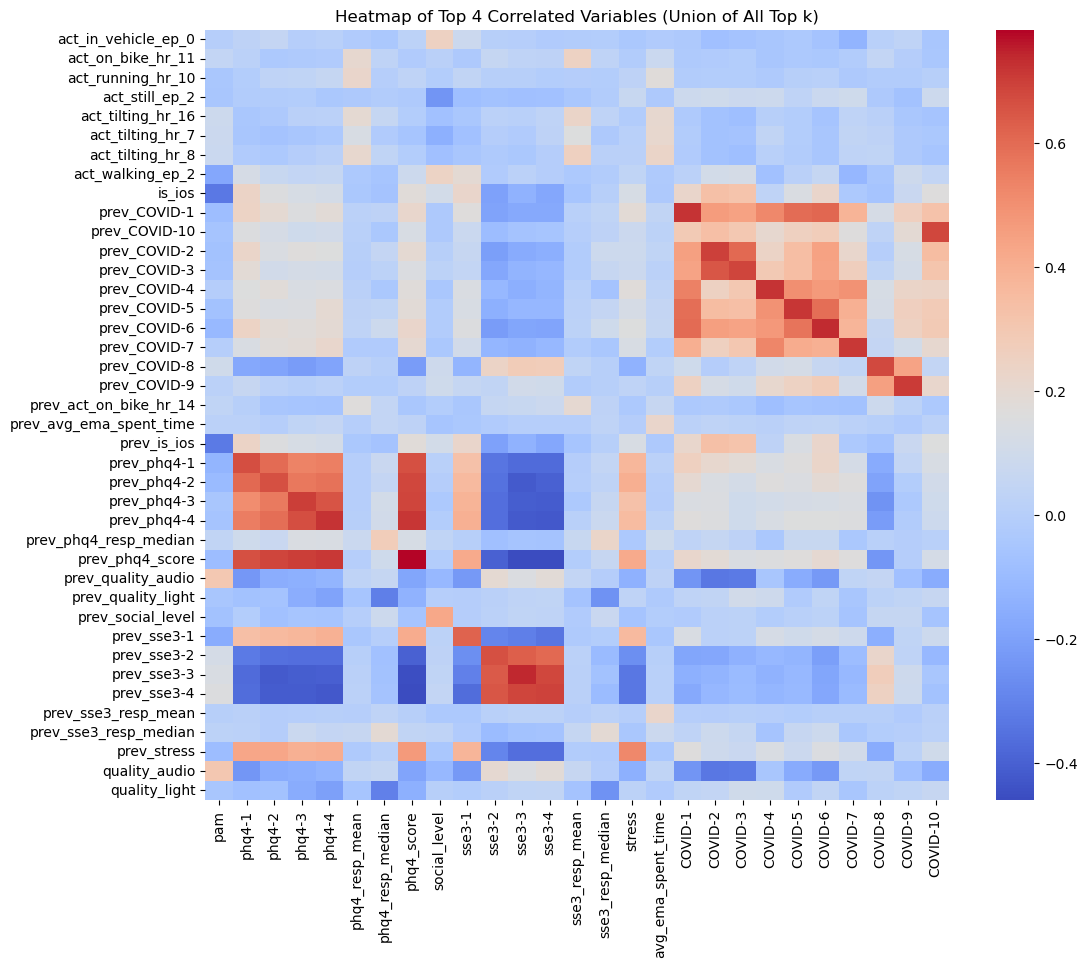

,pam,phq4-1,phq4-2,phq4-3,phq4-4,phq4_resp_mean,phq4_resp_median,phq4_score,social_level,sse3-1,...,COVID-1,COVID-2,COVID-3,COVID-4,COVID-5,COVID-6,COVID-7,COVID-8,COVID-9,COVID-10
act_in_vehicle_ep_0,-0.001399,0.027013,0.052162,-0.000459,0.008863,-0.018967,-0.038925,0.023814,0.253561,0.081514,...,-0.031564,-0.079260,-0.063839,-0.049209,-0.035558,-0.061357,-0.133208,0.008725,0.035380,-0.051143
act_on_bike_hr_11,0.048955,0.017818,-0.034059,-0.026031,-0.017932,0.207876,0.033015,-0.017756,0.014910,-0.029474,...,-0.025868,-0.021486,-0.009219,-0.049812,-0.036275,-0.041219,-0.014972,0.047636,-0.004650,-0.046009
act_running_hr_10,-0.042422,-0.011304,0.035475,0.040310,0.055894,0.221499,0.000534,0.034992,-0.009120,0.043426,...,-0.015493,-0.010048,-0.012162,-0.022993,0.006064,0.009330,-0.029545,-0.013016,-0.012927,0.005960
act_still_ep_2,-0.049755,-0.015403,-0.014775,-0.010967,-0.038618,-0.031210,-0.016188,-0.023453,-0.244917,-0.082328,...,0.085031,0.096441,0.083673,0.084350,0.035227,0.077096,0.096422,-0.031243,-0.070257,0.088190
act_tilting_hr_16,0.087639,-0.043516,-0.027567,0.015835,0.020336,0.196713,0.056814,-0.008865,-0.073523,-0.045492,...,-0.025025,-0.068596,-0.080739,0.004589,-0.011497,-0.056543,0.032374,0.013095,-0.043836,-0.058249
act_tilting_hr_7,0.083458,-0.047863,-0.063301,-0.046769,-0.033195,0.132759,-0.017868,-0.053971,-0.147156,-0.073530,...,-0.012771,-0.066955,-0.063847,0.042044,-0.010772,-0.050212,0.041957,0.028489,-0.030642,-0.037996
act_tilting_hr_8,0.079278,-0.021991,-0.033361,-0.003225,0.016177,0.214390,0.035779,-0.011608,-0.078861,-0.050691,...,-0.019401,-0.066505,-0.084404,0.010867,-0.014134,-0.049688,0.035155,0.036842,-0.031774,-0.054080
act_walking_ep_2,-0.177796,0.127171,0.067089,0.050169,0.059140,-0.036545,-0.054422,0.085785,0.240249,0.193763,...,0.020734,0.113080,0.120164,-0.075602,0.011684,0.057331,-0.116330,-0.049731,0.089602,0.048496
is_ios,-0.328440,0.237377,0.156729,0.129066,0.118046,-0.038481,-0.063094,0.179302,0.110068,0.222498,...,0.221019,0.333718,0.318285,0.032521,0.143241,0.223273,-0.036900,-0.060634,0.072885,0.163752
prev_COVID-1,-0.087196,0.240018,0.196614,0.156390,0.183494,0.018003,0.030629,0.218717,-0.027703,0.170756,...,0.723374,0.466234,0.445907,0.522130,0.595359,0.610974,0.380713,0.125438,0.263251,0.323809


In [34]:
# Define the top k value
top_k = 4  # Adjust as needed

# Compute the correlation matrix

corr_matrix = combined_weekdays_df.drop(columns=['uid']).corr()[target_cols]
corr_matrix = corr_matrix.drop(index=target_cols, errors='ignore')
#corr_matrix = combined_quarters_df[target_cols].corr()

# Mask self-correlations by setting the diagonal to NaN
#np.fill_diagonal(corr_matrix.values, np.nan)

# Collect top k correlated features for each feature
top_k_features = set()  # Use a set to ensure uniqueness

for feature in corr_matrix.columns:
    # Get the top k correlated features for the current feature
    top_k_corr = corr_matrix[feature].abs().nlargest(top_k).index
    top_k_features.update(top_k_corr)

# Convert the set to a sorted list for consistent ordering
top_k_features = sorted(top_k_features)
print(len(top_k_features))
print(corr_matrix.shape)
print(corr_matrix.loc[top_k_features].shape)

# Filter the correlation matrix to only include the union of top k features
filtered_corr_matrix = corr_matrix.loc[top_k_features]

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title(f"Heatmap of Top {top_k} Correlated Variables (Union of All Top k)")
plt.show()
filtered_corr_matrix

In [35]:
results_selected_features = train_and_evaluate_models_normalized(combined_weekdays_df, top_k_features, target_cols)

Training model for target: pam
Normalized RMSE for pam: 0.2698578388005759

Training model for target: phq4-1
Normalized RMSE for phq4-1: 0.17865654964005218

Training model for target: phq4-2
Normalized RMSE for phq4-2: 0.18548789801017418

Training model for target: phq4-3
Normalized RMSE for phq4-3: 0.172466487098063

Training model for target: phq4-4
Normalized RMSE for phq4-4: 0.17513665957295765

Training model for target: phq4_resp_mean
Normalized RMSE for phq4_resp_mean: 0.05618028240586604

Training model for target: phq4_resp_median
Normalized RMSE for phq4_resp_median: 0.031195400203550844

Training model for target: phq4_score
Normalized RMSE for phq4_score: 0.13432793839846513

Training model for target: social_level
Normalized RMSE for social_level: 0.2842881646643636

Training model for target: sse3-1
Normalized RMSE for sse3-1: 0.20871890938552534

Training model for target: sse3-2
Normalized RMSE for sse3-2: 0.20096910234326854

Training model for target: sse3-3
Normal

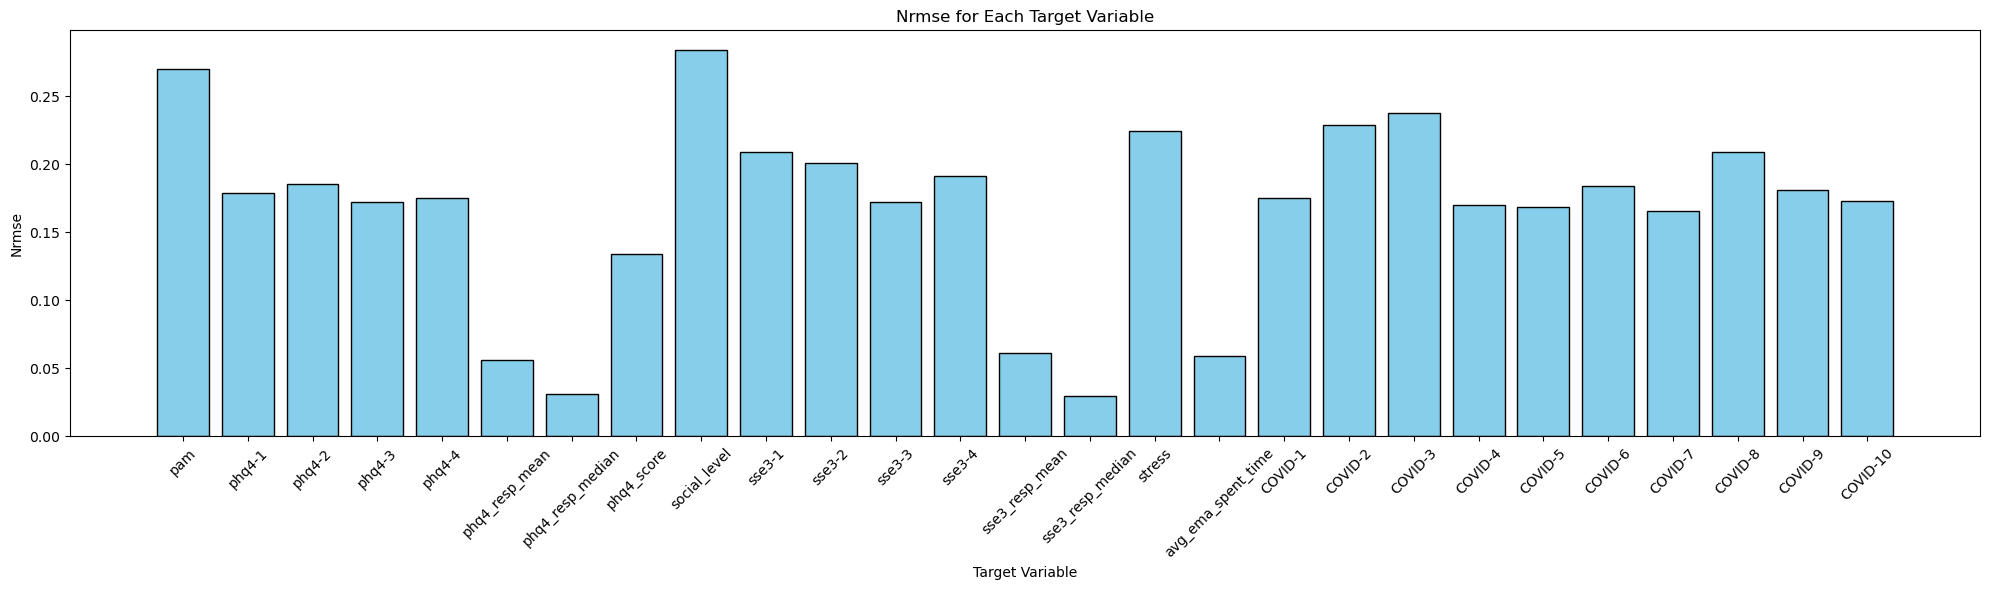

In [36]:
plot_evaluation_results(results_selected_features, metric_name='nrmse')